# Lensed and Unlensed CMB

In [1]:
#imports
import matplotlib.pyplot as plt
import scipy
import astropy.io
from astropy.io import fits
from astropy import wcs
import numpy as np
from numpy import append
import healpy as hp
from cosmology import *
from scipy.interpolate import *
import pixell
from pixell import reproject, enplot, enmap, utils

In [2]:
# variables for Halo catalog
omegab = 0.049
omegac = 0.261
omegam = omegab + omegac
h      = 0.68
ns     = 0.965
sigma8 = 0.81
c = 3e5
H0 = 100*h
nz = 100000
z1 = 0.0
z2 = 6.0
za = np.linspace(z1,z2,nz)
dz = za[1]-za[0]
H = lambda z: H0*np.sqrt(omegam*(1+z)**3+1-omegam)
dchidz = lambda z: c/H(z)
chia = np.cumsum(dchidz(za))*dz
zofchi = interp1d(chia,za)
rho = 2.775e11*omegam*h**2 # Msun/Mpc^3d

In [3]:
# Opens fits files that are in alm form
def read_healpy_alm(file):
    A1 = hp.read_alm(file)
    NSIDE1 = 1024
    return hp.alm2map(A1,NSIDE1)

# Uses healpy to graph fits files that are in alm form
def display_healpy_alm(file): 
    return hp.gnomview(read_healpy_alm(file))

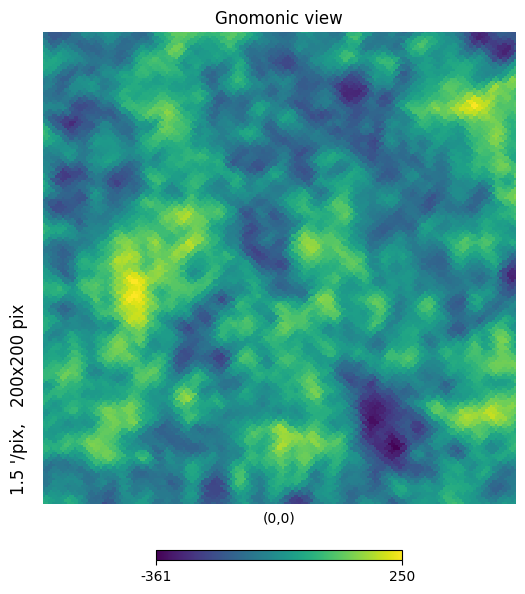

In [4]:
# DON'T RERUN

# Lensed CMB, displayed with healpy
display_healpy_alm('lensed_alm.fits')

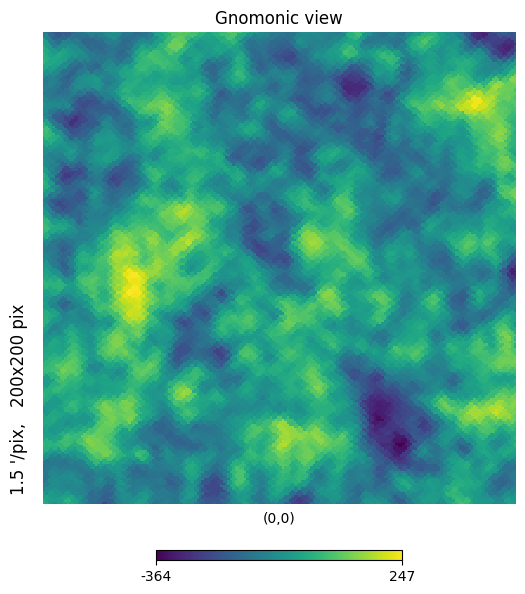

In [25]:
# DON'T RERUN

# Unlensed CMB, displayed with healpy
display_healpy_alm('unlensed_alm.fits')

In [4]:
# Converts alm files to an enmap
def read_enmap_alm(file):
    shape, wcs = enmap.fullsky_geometry(res=0.5 * utils.arcmin, proj='car')
    iheal = read_healpy_alm(file)
    iheal = iheal.astype(np.float32)
    return reproject.healpix2map(iheal,shape,wcs)

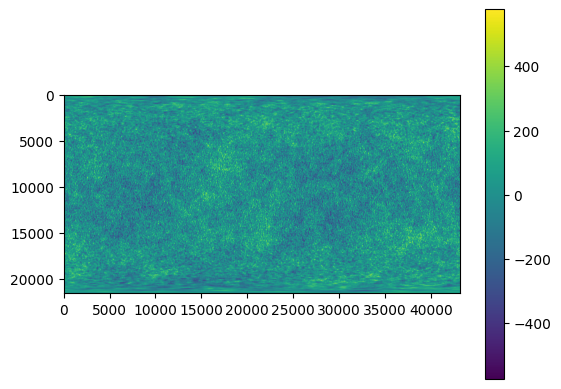

In [7]:
# DON'T RERUN

# Lensed CMB, displayed with pixell
plt.imshow(read_enmap_alm('lensed_alm.fits'))
plt.colorbar()

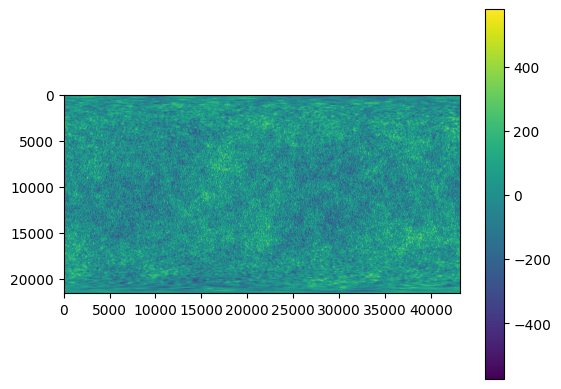

In [26]:
# DON'T RERUN

# Unlensed CMB, displayed with pixell
plt.imshow(read_enmap_alm('unlensed_alm.fits'))
plt.colorbar()

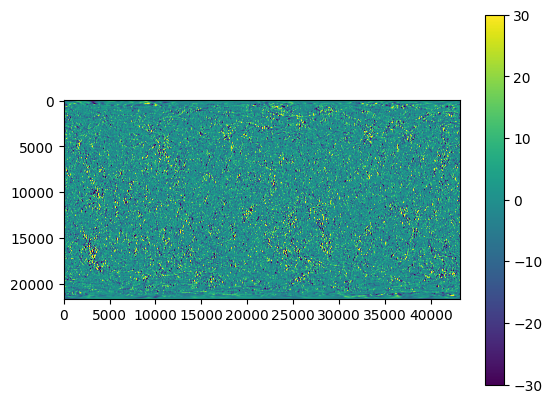

In [44]:
# DON'T RERUN

# Difference between lensed and unleased maps
plt.imshow(read_enmap_alm('lensed_alm.fits')-read_enmap_alm('unlensed_alm.fits'), vmin = -30, vmax = 30)
plt.colorbar()

In [6]:
# ONLY RUN ONCE - these aren't necessary but running them once to create a variable
# will make the rest of the code run faster

# Defines shape and wcs for a full sky projection
shape, wcs = enmap.fullsky_geometry(res=0.5 * utils.arcmin, proj='car')

# Creates a variable for the unlensed enmap
iheal_unlensed1 = read_healpy_alm('unlensed_alm.fits')
iheal_unlensed2 = iheal_unlensed1.astype(np.float32)
unlensed = reproject.healpix2map(iheal_unlensed2,shape,wcs)

# Creates a variable for the lensed enmap
iheal_lensed1 = read_healpy_alm('lensed_alm.fits')
iheal_lensed2 = iheal_lensed1.astype(np.float32)
lensed = reproject.healpix2map(iheal_lensed2,shape,wcs)

In [8]:
# Opens the first N terms in the Halos Catalog
f=open('halos.pksc')
N = 1000000
Nhalo = np.fromfile(f, count=3, dtype=np.int32)[0]
catalog=np.fromfile(f,count=N*10,dtype=np.float32)

In [9]:
# Converts catalog data into a useful form

catalog=np.reshape(catalog,(N,10))
x  = catalog[:,0];  y = catalog[:,1];  z = catalog[:,2] # Mpc (comoving)
vx = catalog[:,3]; vy = catalog[:,4]; vz = catalog[:,5] # km/sec
R  = catalog[:,6] # Mpc

# convert to mass, comoving distance, radial velocity, redshfit, RA and DEc
M200m    = 4*np.pi/3.*rho*R**3        # this is M200m (mean density 200 times mean) in Msun
chi      = np.sqrt(x**2+y**2+z**2)    # Mpc
vrad     = (x*vx + y*vy + z*vz) / chi # km/sec
redshift = zofchi(chi)  
theta, phi  = hp.vec2ang(np.column_stack((x,y,z))) # in radians

In [10]:
# From total list of clusters, selects clusters with redshifts between .7 and 1.3
def redshift_selection(list):
    return list[np.logical_and(redshift>.7,redshift<1.3)]

# From the list of clusters between .7 and 1.3 redshift, selects clusters with mass greater than 5*10**14
def mass_selection(list):
    return redshift_selection(list)[np.greater_equal(redshift_selection(M200m), 5*10**14)]

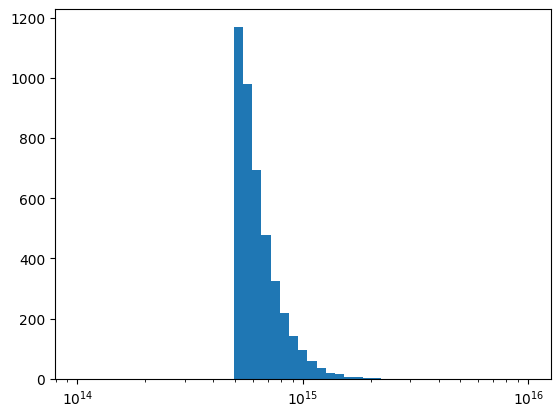

In [95]:
# DON'T RERUN

# Shows distribution of selected masses
plt.hist(mass_selection(M200m), bins=np.geomspace(1*10**14, 1*10**16,50))
plt.xscale('log')

In [11]:
# Gives new list of coordinates for selected clusters
new_theta = mass_selection(theta)
new_phi = mass_selection(phi)

In [12]:
# Converts colatitude and longitude into declination and right assencion
# Theta = colatitude, phi = longitude

def read_halo(i):
    lat = np.pi/2 - new_theta
    return lat[i], new_phi[i]

In [66]:
# Creates thumbnail around selected coordinates
def thumbnail(i, list, enmap):
    coords = list(i)
    return reproject.thumbnails(enmap,coords,r=10*utils.arcmin)

In [68]:
# Stacks unrotated thumbnails
def averaged_map_lensed(k, list, enmap):
    image_list = []
    #add thumbnails to an array
    for z in range(k):
        image_list.append(thumbnail(z, list, enmap))
    # Stacks thumbnails into a single NumPy array
    stacked_images = np.stack(image_list, axis = 0)
    # Computes the average of the stacked thumbnails, unweighted
    return np.average(stacked_images, axis = 0)

# Note: plotting this function for k thumbnails should not produce a clear gradient

In [69]:
# Rotates selected thumbnail
def rotate_thumbnail(input):
    # takes the gradient of the thumbnail
    y_grad, x_grad = np.gradient(input)
    # average gradient of x and y arrays
    x_ave = np.mean(x_grad)
    y_ave = np.mean(y_grad)
    # finds angle of rotation
    rad_angle = np.arctan2(y_ave,x_ave)
    return scipy.ndimage.rotate(input, np.rad2deg(rad_angle), reshape = False, mode='constant', cval=np.nan)

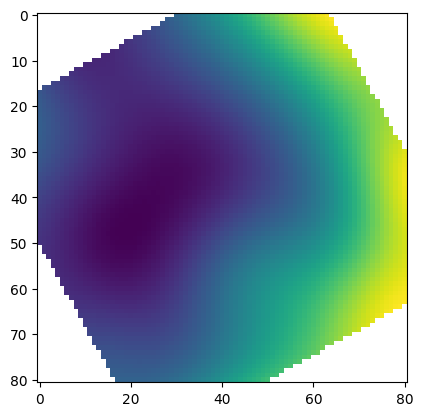

In [70]:
plt.imshow(rotate_thumbnail(thumbnail(0, read_halo, lensed)))

In [71]:
# Calculates the magnitude of the average gradient of a thumbnail
def get_gradient(i, list, enmap):
    y_grad, x_grad = np.gradient(thumbnail(i, list, enmap))
    x_ave = np.mean(x_grad)
    y_ave = np.mean(y_grad)
    return np.sqrt(x_ave**2 + y_ave**2)

In [72]:
# Stacks rotated thumbnails
def averaged_map_rotated(k, list, enmap):
    image_list_rotated = []
    gradient_array = []
    #add rotated thumbnails to an array
    for i in range(k):
        grad = get_gradient(i, list, enmap)
        # multiplies rotated thumbnail by the magnitude of its gradient
        stamp = rotate_thumbnail(thumbnail(i, list, enmap)) * grad
        image_list_rotated.append(stamp)
        gradient_array.append(grad)
    # Stack the images into a single NumPy array
    stacked_images_rotated = np.stack(image_list_rotated, axis = 0)
    # Compute the weighted average of the stacked thumbnails
    return np.average(stacked_images_rotated, axis = 0, weights= gradient_array)

# Note: plotting this function for k thumbnails should produce a clear gradient in the positive x direction

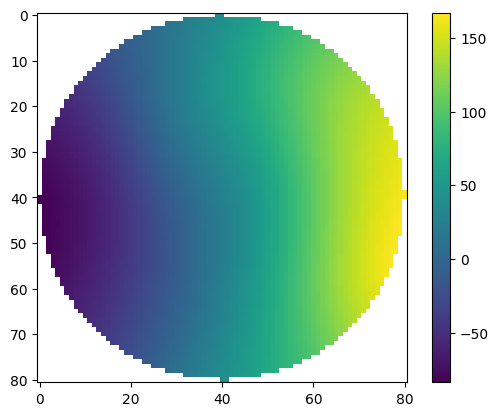

In [73]:
# DON'T RERUN

plt.imshow(averaged_map_rotated(100, read_halo, lensed))
plt.colorbar()

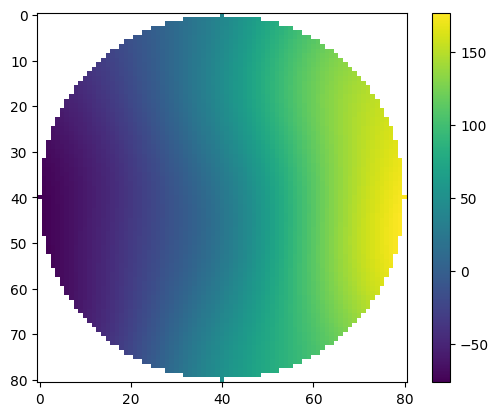

In [74]:
# DON'T RERUN

plt.imshow(averaged_map_rotated(100, read_halo, unlensed))
plt.colorbar()

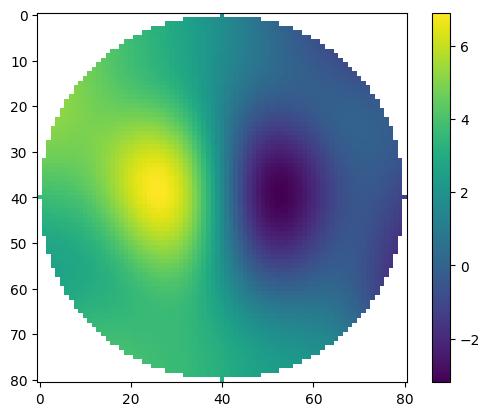

In [75]:
# DON'T RERUN

plt.imshow(averaged_map_rotated(4000, read_halo, lensed) - 
           averaged_map_rotated(4000, read_halo, unlensed))
plt.colorbar()

# Random Thumbnails

Because we don't have data for unlensed CMB, this section does the same thing but with random thumbnails of the lensed CMB map in place of the unleased CMB thumbnails

In [52]:
# Creates coordinates for random locations in the lensed CMB map

np.random.seed(5)

lower_theta = 0  # Lower bound (inclusive)
upper_theta = np.pi  # Upper bound (exclusive)

# Generate an array of random numbers for theta
random_theta = np.random.uniform(lower_theta, upper_theta, size=(4000,))

lower_phi = 0  # Lower bound (inclusive)
upper_phi = 2*np.pi  # Upper bound (exclusive)

# Generate an array of random numbers for phi
random_phi = np.random.uniform(lower_phi, upper_phi, size=(4000,))

In [53]:
# Converts random coordinates to latitude and longitude
def read_halo_random(i):
    random_lat = np.pi/2 - random_theta
    return random_lat[i], random_phi[i]

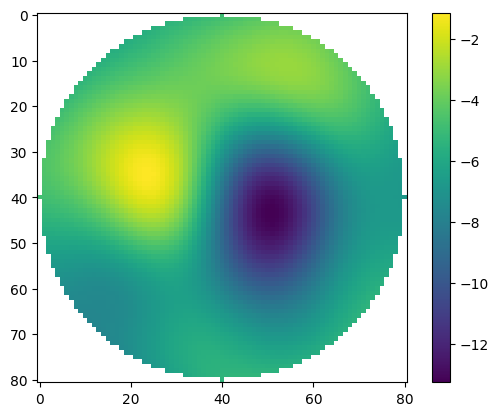

In [77]:
# Plots the difference between rotated thumbnails around clusters and random rotated thumbnails
plt.imshow(averaged_map_rotated(4000, read_halo, lensed) - 
           averaged_map_rotated(4000, read_halo_random, lensed))
plt.colorbar()

# Gradient Maps

This next section can be used to test the gradient rotation method

In [78]:
# This function makes a map with a constant gradient at a given angle
def make_gradient(angle):
    theta = np.deg2rad(angle)
    shape, wcs = enmap.geometry(pos=(0,0), res= .5*utils.arcmin, proj = 'tan', shape = (80,80))
    y,x = enmap.posmap(shape, wcs)
    a = np.tan(theta)
    rotx = x*np.cos(theta) - y*np.sin(theta)
    roty = x*np.sin(theta) + y*np.cos(theta)
    return rotx + roty

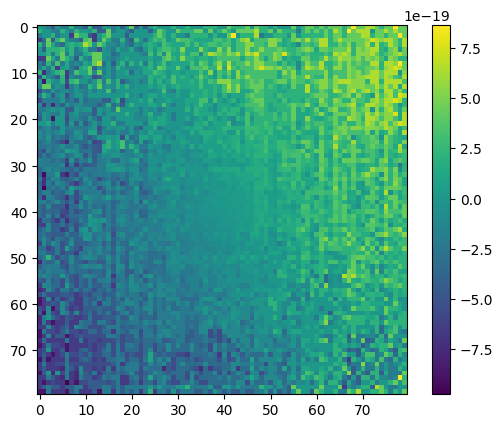

In [46]:
# DON'T RERUN
# This shows that stacked maps with gradients at different angles don't produce a clear gradient

arrays = [make_gradient(0), make_gradient(45), make_gradient(90), 
          make_gradient(135), make_gradient(180), make_gradient(225), 
          make_gradient(270), make_gradient(315)]
stacked = np.stack(arrays, axis=0)
averaged = np.mean(stacked, axis=0)
plt.imshow(averaged)
plt.colorbar()

In [79]:
# This function tests that the method in the rotate_thumbnail function rotates gradients to the alignment
def rotate_thumbnail_test(input):
    shape, wcs = enmap.fullsky_geometry(res=0.5 * utils.arcmin, proj='car')
    y,x = enmap.posmap(shape, wcs)
    y_grad, x_grad = np.gradient(input)
    x_ave = np.mean(x_grad)
    y_ave = np.mean(y_grad)
    # finds angle of rotation
    rad_angle = np.arctan2(y_ave,x_ave)
    return scipy.ndimage.rotate(input, np.rad2deg(rad_angle), reshape = False, mode='constant', cval=np.nan)

# Quiver Plots

This section is another way of testing the gradient rotation method 

In [87]:
# This function produces a 10 x 10 map of gradient arrows (red) for a given thumbnail
# as well as an arrow (white) showing the average gradient of the whole thumbnail

def quiver_plot(input):
    y_grad, x_grad = np.gradient(input)
    # Create masked arrays to handle NaN values
    x_grad_masked = np.ma.masked_invalid(x_grad)
    y_grad_masked = np.ma.masked_invalid(y_grad)
    x_ave = np.mean(x_grad_masked)
    y_ave = np.mean(y_grad_masked)
    rad_angle = np.arctan2(y_ave,x_ave)

    # Define the number of arrows in the grid
    num_arrows = 10

    # Calculate the stride for the grid
    stride = input.shape[0] // num_arrows

    # Create the meshgrid of arrow positions
    x_coordinates, y_coordinates = np.meshgrid(np.arange(0, input.shape[1], stride),
                                           np.arange(0, input.shape[0], stride))
    x_coordinates = x_coordinates.flatten()
    y_coordinates = y_coordinates.flatten()

    # Plot the image
    plt.imshow(input)

    # Plot the quiver plot at the evenly spaced locations
    scale_factor = .3  # Adjust the scale factor to make the arrows bigger
    arrow_width = .008 # Adjust the arrow width to make the arrow shaft wider
    arrow_headwidth = 5  # Adjust the arrow headwidth to make the arrowhead wider

    plt.quiver(x_coordinates, y_coordinates, x_grad[y_coordinates, x_coordinates], 
               y_grad[y_coordinates, x_coordinates], angles='xy', scale_units='xy', 
               scale=scale_factor, width=arrow_width, headwidth=arrow_headwidth, color='red')

    plt.quiver(40,40, x_ave, y_ave, angles='xy', scale_units='xy', scale=.1, color='white')
    
    return plt.show()

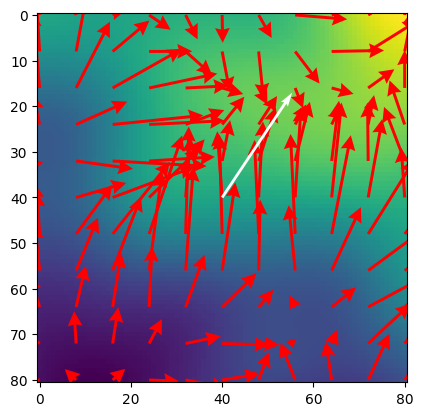

In [90]:
quiver_plot(thumbnail(6, read_halo, lensed))

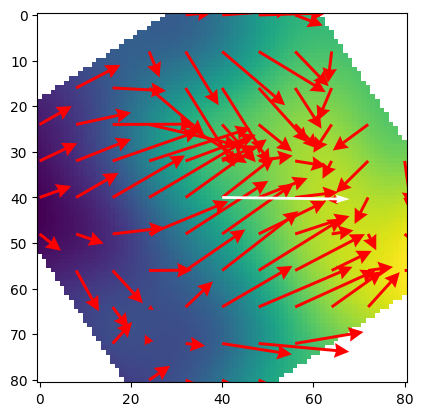

In [91]:
quiver_plot(rotate_thumbnail(thumbnail(6, read_halo, lensed)))